<a href="https://colab.research.google.com/github/LarsAmker/ExplainGAN/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
#!pwd
!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

### Upload the kaggle.json file manually in the left hand pane

In [0]:
# copy the json file into the kaggle directory
!cp kaggle.json ~/.kaggle/

In [0]:
# Check what files and directories are in the current working directory. -a makes hidden ones (starting with .) visible
!ls -a

In [0]:
# Download pneumonia data (first line makes kaggle API key unreadable)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# the zip file is listed in the left hand pane after the download. We need to unzip and create paths

In [0]:
!unzip chest-xray-pneumonia.zip

# NAIN's kaggle kernel

Now try to rebuild the top kernel from kaggle (https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution). This is the classifier I would like to explain with ExplainGAN.

Modifications compared to the original code of the kernel are mentioned when they appear.

In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

In [0]:
# My directory is called "content" instead of "input" as in the original code
os.listdir("../content/chest_xray/chest_xray") 

Reproducibility is a great concern when doing deep learning. There was a good discussion on KaggleNoobs slack regarding this. We will set a numer of things in order to make sure that the results are almost reproducible(if not fully).

In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

The dataset is divided into three sets: 1) train set 2) validation set and 3) test set. Let's grab the dataset

In [0]:
# Define path to the data directory: "content" instead of "input/chest-xray-pneumonia" as in the original code
data_dir = Path('../content/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

We will first go through the training dataset. We will do some analysis on that, look at some of the samples, check the number of samples for each class, etc. Lets' do it.
Each of the above directory contains two sub-directories:

NORMAL: These are the samples that describe the normal (no pneumonia) case.

PNEUMONIA: This directory contains those samples that are the pneumonia cases.

In [0]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

1    3875
0    1341
Name: label, dtype: int64


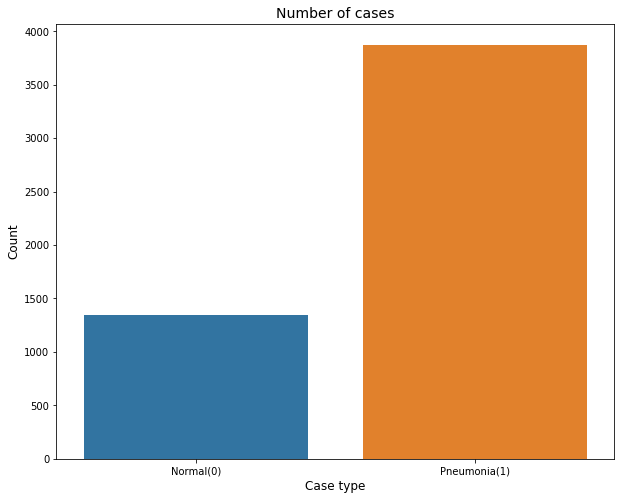

In [32]:
# How many samples for each class are there in the dataset?
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.

Let's look at how a normal case is different from that of a pneumonia case. We will look at somes samples from our training data itself.

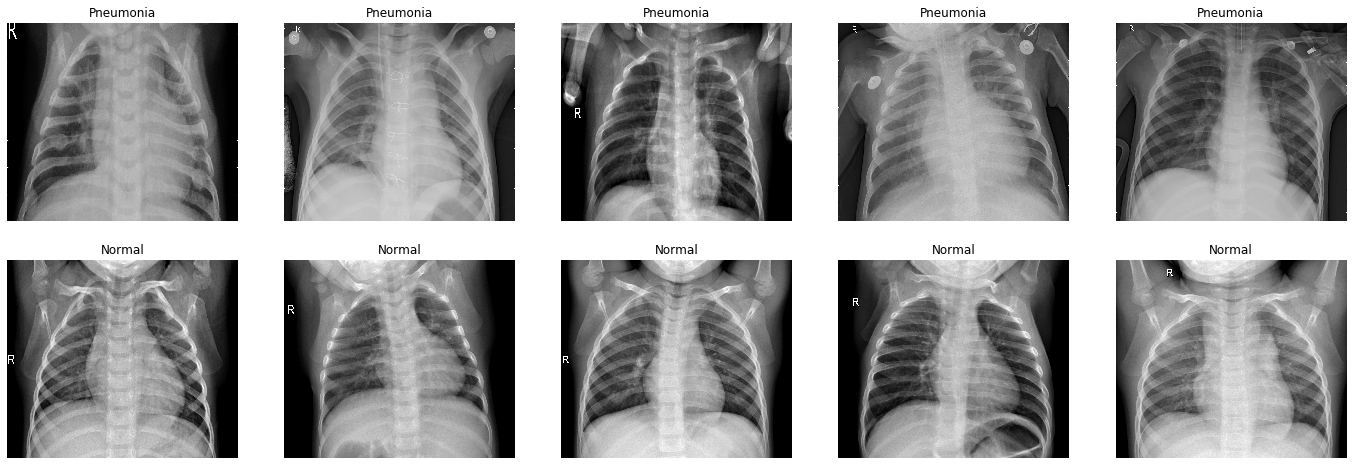

In [35]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(24,8))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

###Preparing validation data
We will be defining a generator for the training dataset later in the notebook but as the validation data is small, so I can read the images and can load the data without the need of a generator. This is exactly what the code block given below is doing.

In [0]:
# Do I want RGB or should I change it to Greyscale for all pictures maybe?
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. 
# So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img]) # add a third dimension for RGB channels and fill it with 3 copies of the original
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

(-0.5, 223.5, 223.5, -0.5)

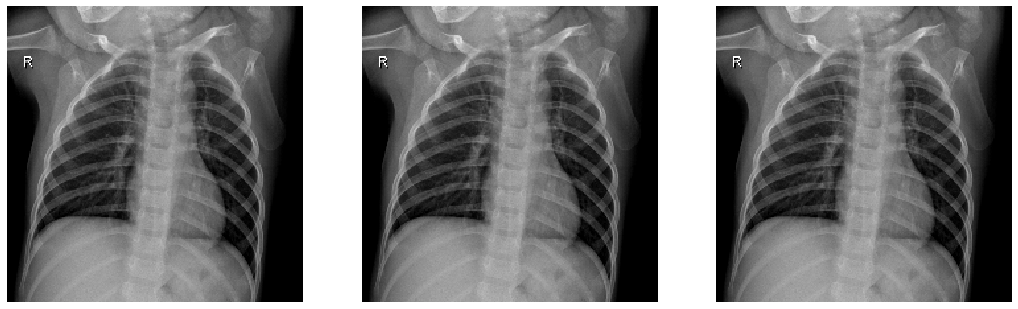

In [36]:
# Check quality: The image is still pretty clear after the reduction of pixels to 224*224
#valid_data[0,:,:,0]
fig = plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(valid_data[1, :, :, 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(valid_data[1, :, :, 1], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(valid_data[1, :, :, 2], cmap='gray')
plt.axis('off')
# All 3 RGB channels show the same picture. Is RGB really necessary?

###Augmentation (stop ExplainGAN preprocessing before this?)
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. You can generate different samples of undersampled class in order to try to balance the overall distribution.
I like imgaug a lot. It comes with a very clean api and you can do hell of augmentations with it. It's worth exploring!! In the next code block, I will define a augmentation sequence. You will notice Oneof and it does exactly that. At each iteration, it will take one augmentation technique out of the three and will apply that on the samples

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

###Training data generator

Here I will define a very simple data generator. You can do more than this if you want but I think at this point, this is more than enough I need.

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

###Model
This is the best part. If you look at other kernels on this dataset, everyone is busy doing transfer learning and fine-tuning. You should transfer learn but wisely. We will be doing partial transfer learning and rest of the model will be trained from scratch. I will explain this in detail but before that, I would love to share one of the best practices when it comes to building deep learning models from scratch on limited data.

1 Choose a simple architecture.

2 Initialize the first few layers from a network that is pretrained on imagenet. This is because first few layers capture general details like color blobs, patches, edges, etc. Instead of randomly initialized weights for these layers, it would be much better if you fine tune them.

3 Choose layers that introduce a lesser number of parameters. For example, Depthwise SeparableConv is a good replacement for Conv layer. It introduces lesser number of parameters as compared to normal convolution and as different filters are applied to each channel, it captures more information. Xception a powerful network, is built on top of such layers only. You can read about Xception and Depthwise Separable Convolutions in this paper.

4 Use batch norm with convolutions. As the network becomes deeper, batch norm start to play an important role.

5 Add dense layers with reasonable amount of neurons. Train with a higher learning rate and experiment with the number of neurons in the dense layers. Do it for the depth of your network too. 

6 Once you know a good depth, start training your network with a lower learning rate along with decay. 

This is all that I have done in the next code block.

In [0]:
# There are some warning messages about deprecated functions from tensorflow. But I don't see them anywhere - ?
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model =  build_model()
model.summary()

### Upload the vgg16 file manually in the left hand pane
We will initialize the weights of first two convolutions with imagenet weights. They are contained in the vgg16 file listed on NAIN's kernel under data. Unzip it after uploading.

In [0]:
!unzip vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5.zip

In [0]:
# Open the VGG16 weight file.
f = h5py.File('../content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

In [23]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [25]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})



Epoch 1/20
326/326 [==============================] - 204s 627ms/step - loss: 0.2290 - acc: 0.7691 - val_loss: 0.6309 - val_acc: 0.6875
Epoch 2/20
326/326 [==============================] - 191s 586ms/step - loss: 0.0739 - acc: 0.9513 - val_loss: 0.1932 - val_acc: 0.9375
Epoch 3/20
326/326 [==============================] - 191s 586ms/step - loss: 0.0624 - acc: 0.9615 - val_loss: 2.0672 - val_acc: 0.5625
Epoch 4/20
326/326 [==============================] - 191s 586ms/step - loss: 0.0496 - acc: 0.9684 - val_loss: 0.1802 - val_acc: 0.9375
Epoch 5/20
326/326 [==============================] - 192s 588ms/step - loss: 0.0480 - acc: 0.9701 - val_loss: 0.5267 - val_acc: 0.6875
Epoch 6/20
326/326 [==============================] - 191s 585ms/step - loss: 0.0416 - acc: 0.9712 - val_loss: 0.1828 - val_acc: 0.9375
Epoch 7/20
326/326 [==============================] - 191s 585ms/step - loss: 0.0374 - acc: 0.9778 - val_loss: 0.3218 - val_acc: 0.8750
Epoch 8/20
326/326 [==========================

In [26]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [27]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 5s 8ms/step
Loss on test set:  1.1711223510739774
Accuracy on test set:  0.8108974358974359


In [28]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


When a particular problem includes an imbalanced dataset, then accuracy isn't a good metric to look for. For example, if your dataset contains 95 negatives and 5 positives, having a model with 95% accuracy doesn't make sense at all. The classifier might label every example as negative and still achieve 95% accuracy. Hence, we need to look for alternative metrics. Precision and Recall are really good metrics for such kind of problems.

We will get the confusion matrix from our predictions and see what is the recall and precision of our model.

<Figure size 432x288 with 0 Axes>

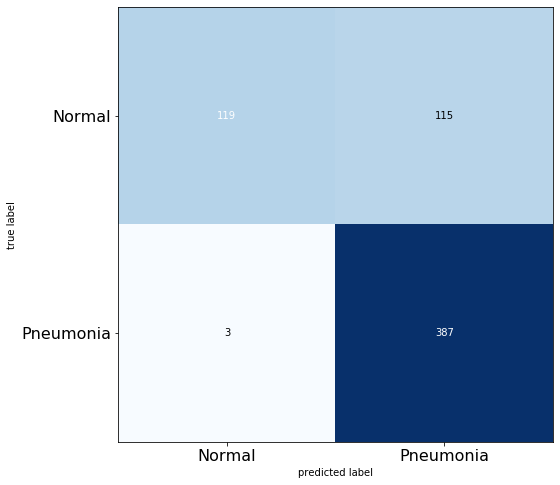

In [30]:
# Get the confusion matrix
cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
#plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [31]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.77


###Results
First training: Confusion matrix 119,115,3,387 -> Higher recall, worse precision than NAIN's best model. My model is leaning more towards predicting pneumonia. Accuracy on test set is 81% (NAIN had 82.7%).